In [1]:
%load_ext autoreload
%autoreload 2

# Split buckets into clusters and super-clusters using cross-encoder

Load the parser and trained model, and use a hierarchal agglomerative clustering algorithm to split existing FamilySearch buckets into clusters and super-clusters based upon similarity computed using the cross-encoder model. Each cluster contains the names in the bucket that the model determines are similar to each other, and each super-cluster contains all of the clusters in the bucket.

Each cluster contains:

1. a list of names, 
2. the most-common name as the cluster label, and 
3. a cluster centroid: a vector depicting the center of the cluster using a bi-encoder. 

Each super-cluster contains:

1. a list of cluster labels
2. the most-common name in the cluster as the super-cluster label

If a bucket has only one cluster, we don't create a super-cluster for the bucket.

When determine which cluster a rare name belongs to, we will choose the closest centroid.

The questions to answer are:

1. What should the threshold be?

ISSUES
- cross-encoder scores much lower than bi-encoder: why?
    - do we need to combine both scores?
    - is cross-encoder really wrong when it scores near 0?
- why is the cross-encoder score so much lower than the bi-encoder score?
- is taking the average cross-encoder score the right thing to do?
    - what about taking the max score for each name, and then averaging the maximums???
- does the problem go away if we take the average of the two ce scores instead of the harmonic mean?
    - is the bi-encoder closer to the average or the harmonic mean?
- we should try to **graph** correlation between Y=bi-encoder score and X=average vs harmonic mean of ce score
- when you sort the two scores, is the order different?

larger ttest is better, smaller mann is better
t_ttest, _ = ttest_ind(random_pair_scores, non_negative_scores, equal_var=False)
t_mann, _  = mannwhitneyu(random_pair_scores, non_negative_scores, use_continuity=False)
print(int(abs(t_ttest)), int(t_mann/1_000_000))

In [41]:
from collections import defaultdict
import json
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers.cross_encoder import CrossEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from statistics import harmonic_mean
import torch
from tqdm.notebook import tqdm

from nama.data.filesystem import download_file_from_s3, save_file
from nama.models.tokenizer import get_tokenize_function_and_vocab

os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [14]:
# config
# TODO run both given and surname
given_surname = "given"
# given_surname = "surname"

# hyperparameters
linkage = "average"  # average, complete
similarity_threshold = 0.1 if given_surname == "given" else 0.25
cluster_freq_normalizer = "none"  # log, log10, none

experiment_name = f"{linkage}-{similarity_threshold}-{cluster_freq_normalizer}"

max_tokens = 10
bi_encoder_vocab_size = 2048
cross_encoder_vocab_size = 265
num_epochs = 8
embedding_dim = 256
learning_rate = 0.00005 
tokenizer_max_length = 32

std_path = f"../references/std_{given_surname}.txt"
pref_path = f"s3://fs-nama-data/2024/familysearch-names/processed/tree-preferred-{given_surname}-aggr.csv.gz"
tokenizer_path=f"s3://fs-nama-data/2024/nama-data/data/models/fs-{given_surname}-subword-tokenizer-{bi_encoder_vocab_size}.json"
bi_encoder_path = f"s3://fs-nama-data/2024/nama-data/data/models/bi_encoder-ce-{given_surname}-{num_epochs}-{embedding_dim}-{num_epochs}-{bi_encoder_vocab_size}-{learning_rate}.pth"
cross_encoder_dir = f"../data/models/cross-encoder-{given_surname}-{cross_encoder_vocab_size}"
cross_encoder_dir_s3 = f"s3://fs-nama-data/2024/nama-data/data/models/cross-encoder-{given_surname}-{cross_encoder_vocab_size}/"

# experiment_dir = f"../reports/"
clusters_path = f"s3://fs-nama-data/2024/nama-data/data/processed/clusters_{given_surname}-{linkage}-{similarity_threshold}-{cluster_freq_normalizer}.json"
super_clusters_path = f"s3://fs-nama-data/2024/nama-data/data/processed/super_clusters_{given_surname}-{linkage}-{similarity_threshold}-{cluster_freq_normalizer}.json"
clusters_path

's3://fs-nama-data/2024/nama-data/data/processed/clusters_given-average-0.1-none.json'

## Load data

In [4]:
def get_cluster_freq(name):
    freq = name_freq.get(name, 0)
    if cluster_freq_normalizer == "log":
        return max(1, math.floor(math.log(max(1,freq))))
    elif cluster_freq_normalizer == "log10":
        return max(1, math.floor(math.log10(max(1,freq))))
    else:
        return 1

In [5]:
# load buckets
bucket_names = defaultdict(set)
name_buckets = defaultdict(set)
with open(std_path, 'rt') as f:
    for line in f.readlines():
        names = line.strip().replace(':', ' ').split(' ')
        bucket_name = names[0]
        for name in names:
            name = name.strip()
            if len(name) == 0:
                continue
            bucket_names[bucket_name].add(name)
            name_buckets[name].add(bucket_name)
print(len(bucket_names), len(name_buckets))

8878 95997


In [6]:
# load pref names
path = download_file_from_s3(pref_path) if pref_path.startswith("s3://") else pref_path
pref_df = pd.read_csv(path, na_filter=False)
name_freq = {name: freq for name, freq in zip(pref_df['name'], pref_df['frequency'])}
pref_df = None
print(len(name_freq))
print('john', name_freq['john'], get_cluster_freq('john'))

2691517
john 35659133 1


In [7]:
cnt = 0
for name in name_buckets:
    if name not in name_freq:
        cnt += 1
        print(name)
print(cnt)

abdn
abr
adoracin
aryantie
alex
alexr
almaricus
amuleck
ant
art
aug
baby
brbaro
bart
benedam
benj
betsab
bngta
borrodil
kecizza
capt
chas
chasf
chloedean
chrtien
chloery
col
croml
cstula
dmasa
dmaso
danl
dahnelle
daughter
deceased
dit
edw
edwd
nd
eliz
elizth
elisab
esq
experinece
father
fedrzej
feramorze
filemn
feralie
franoyse
frdrique
frderique
fr
freswede
froiln
gen
geo
gjerson
gheorghios
gmez
gnvieve
gnevive
gppa
hel
dr
hen
huybartus
husband
in
ismrie
jas
jathniall
jeremuth
jac
jn
jno
joh
jon
jrand
jaziell
jstoan
jun
hken
kolbjrn
kjr
lpez
lt
lusaine
muoz
maj
malaquas
margt
merebath
mister
mother
matt
mme
miss
melitn
mlitine
mich
michl
haramita
mnico
mordsche
nath
nee
nehimeah
neptal
null
nn
nrgaard
ocotln
odiln
of
ol
onesophorus
pacfica
panajottis
patk
patt
peeril
pet
phil
pnfilo
pnfila
precindia
rgis
rev
rd
richd
ric
robt
rmula
rmulo
rnnaug
sagrdo
saml
zainte
sar
sol
sen
senr
srvulo
sfren
sffren
sgt
shuebal
sim
son
sndergaard
srren
sstenes
sus
thankes
thger
th
thos
thrze
tim
tger


In [8]:
def get_most_freq_name(names):
    most_freq_name = None
    most_freq_freq = None
    for name in names:
        freq = name_freq.get(name, 0)
        if most_freq_name is None or freq > most_freq_freq:
            most_freq_name = name
            most_freq_freq = freq
    return most_freq_name

In [9]:
# download cross encoder
for filename in [
    'CECorrelationEvaluator_dev_results.csv',
    'config.json',
    'merges.txt',
    'special_tokens_map.json',
    'tokenizer_config.json',
    'tokenizer.json',
    'vocab.json',
    'model.safetensors',
]:
    print(filename)
    cross_encoder_dir_filename = os.path.join(cross_encoder_dir, filename)
    if not os.path.exists(cross_encoder_dir_filename):
        print('downloading', filename)
        download_file_from_s3(cross_encoder_dir_s3+filename, cross_encoder_dir_filename)

CECorrelationEvaluator_dev_results.csv
config.json
merges.txt
special_tokens_map.json
tokenizer_config.json
tokenizer.json
vocab.json
model.safetensors


In [10]:
# load cross encoder model
ce_model = CrossEncoder(cross_encoder_dir, max_length=tokenizer_max_length)

In [15]:
# load tokenizer
path = download_file_from_s3(tokenizer_path) if tokenizer_path.startswith("s3://") else tokenizer_path
tokenize, tokenizer_vocab = get_tokenize_function_and_vocab(tokenizer_path=path, max_tokens=max_tokens)
print(len(tokenizer_vocab))
print(tokenize('dallan'))

2048
[1584, 489, 1, 1, 1, 1, 1, 1, 1, 1]


In [32]:
# load bi-encoder
path = download_file_from_s3(bi_encoder_path) if bi_encoder_path.startswith("s3://") else bi_encoder_path
bi_encoder_model = torch.load(path)
bi_encoder_model.eval()

/tmp/ipykernel_3794509/3861995143.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bi_encoder_model = torch.load(path)


BiEncoder(
  (embedding): Embedding(2048, 256)
  (positional_embedding): Embedding(10, 256)
  (pooling): AdaptiveAvgPool1d(output_size=1)
)

## Compare Cross-encoder scores

In [11]:
ce_avg_scores = []
ce_harmonic_scores = []
ce_max_scores = []

for bucket_name, names in tqdm(bucket_names.items(), mininterval=2.0):
    if len(names) == 1:
        continue
    # compute X and clustered_names
    X = []
    names = list(names)
    for name1 in random.sample(names, min(len(names), 3)):
        for name2 in random.sample(names, min(len(names), 3)):
            if name1 == name2:
                continue
            # compute cross-encoder scores
            ce_scores = ce_model.predict([[name1, name2], [name2, name1]])
            ce_harmonic_score = harmonic_mean([ce_scores[0], ce_scores[1]])
            ce_avg_score = (ce_scores[0]+ce_scores[1])/2
            ce_max_score = max(ce_scores[0], ce_scores[1])
            # save them
            ce_harmonic_scores.append(ce_harmonic_score)
            ce_avg_scores.append(ce_avg_score)
            ce_max_scores.append(ce_max_score)

  0%|          | 0/8878 [00:00<?, ?it/s]

In [12]:
for ix, (h, a, m) in enumerate(zip(ce_harmonic_scores, ce_avg_scores, ce_max_scores)):
    if ix > 20:
        break
    print(h, a, m)

0.41594246 0.41607988 0.42364115
0.41594246 0.41607988 0.42364115
0.4468008 0.44680083 0.44692123
0.4468008 0.44680083 0.44692123
0.7332878 0.73329926 0.73620284
0.796797 0.7967981 0.7977691
0.8146019 0.81553173 0.84307
0.6679859 0.66802 0.67279094
0.9250009 0.9250026 0.9262551
0.6679859 0.66802 0.67279094
0.678243 0.6783214 0.68561524
0.5436077 0.5440835 0.56017196
0.5436077 0.5440835 0.56017196
3.4517816e-06 3.4517839e-06 3.4546283e-06
3.4517816e-06 3.4517839e-06 3.4546283e-06
0.41339672 0.41340476 0.41522828
0.40826103 0.40826333 0.40923145
3.4573338e-06 3.457334e-06 3.4579175e-06
0.41678414 0.41678417 0.4169126
0.48820096 0.48840666 0.49842942
0.41493404 0.41493434 0.41528264


In [17]:
print(len(ce_harmonic_scores), len(ce_avg_scores), len(ce_max_scores))

46365 46365 46365


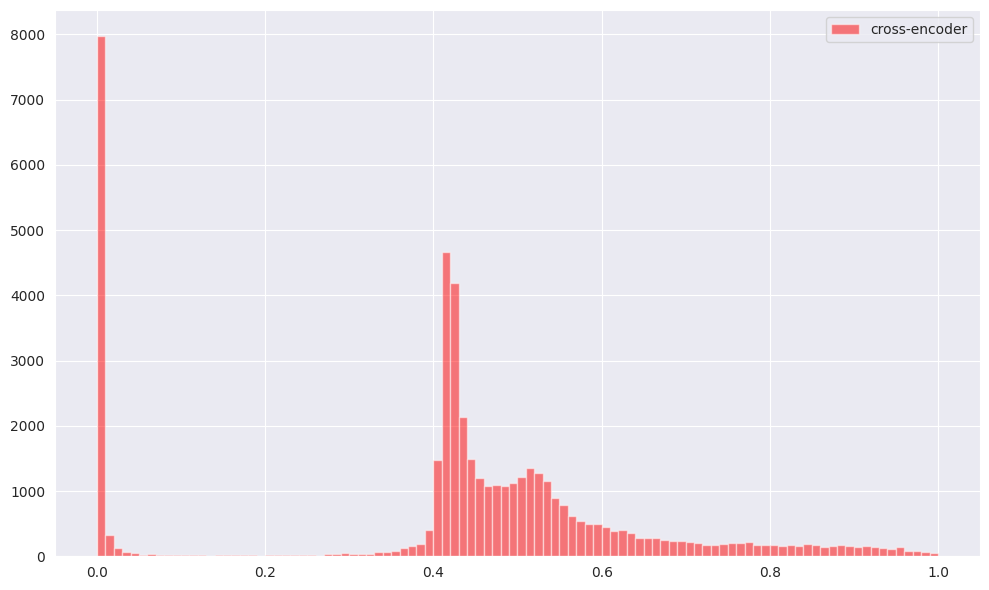

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(ce_harmonic_scores, bins=100, alpha=0.5, label="cross-encoder", color='red')
plt.legend(loc='upper right')
# Show the plot
plt.tight_layout()
plt.show()

## Cluster names

### create clusterer

In [19]:
def compute_row(name, names):
    # compute pairs
    pairs = []
    for name2 in names:
        if name2 != name:
            pairs.append([name, name2])
            pairs.append([name2, name])
    scores = ce_model.predict(pairs) if len(pairs) > 0 else []
    # construct row
    row = []
    ix = 0
    for name2 in names:
        score = 0.0
        if name2 == name:
            score = 1.0
        else:
            score = harmonic_mean([scores[ix], scores[ix+1]])
            ix += 2
                
        # store the distance between name and name2
        for _ in range(get_cluster_freq(name2)):
            row.append(1.0 - score)
    return row

In [20]:
# test different hyperparameters
similarity_threshold = 0.25  # be=0.3, ce=0.08 or 0.15, cebe=0.28
linkage = "average"

In [21]:
clusterer = AgglomerativeClustering(
    n_clusters=None,
    metric="precomputed",
    linkage=linkage,
    distance_threshold=(1-similarity_threshold),
)

### test clusterer

In [22]:
%%time

# test_names = ['david', 'dan', 'daniel', 'dave']  # , 'darris', 'darrin', 'daren',
#               'abraham','abe','aabraham','ab','abaham','abaraham','abarham','abb',
#               'abelarde','abera','aberaham']
# test_names = ['maholy', 'malay', 'mauley', 'ma', 'mala']
test_names = bucket_names['berry']
print(len(test_names))
X = []
names = []
for name in test_names:
    row = compute_row(name, test_names)
    for _ in range(get_cluster_freq(name)):
        names.append(name)
        X.append(row)
print(len(X))
clustering = clusterer.fit(X)
clusters = [set() for _ in range(clustering.n_clusters_)]
print('n_clusters', clustering.n_clusters_)
print('labels', clustering.labels_)
print('names', names)
for name, cluster in zip(names, clustering.labels_):
    clusters[cluster].add(name)
for cluster in clusters:
    print()
    print('cluster', get_most_freq_name(cluster), ':', cluster)

26
26
n_clusters 3
labels [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
names ['beri', 'ber', 'barie', 'beeri', 'barrie', 'dubarry', 'berah', 'beery', 'barry', 'burry', 'bary', 'buri', 'bery', 'bere', 'berrey', 'berr', 'bari', 'bury', 'berrie', 'burie', 'beary', 'beria', 'berry', 'barri', 'berryhill', 'brre']

cluster barry : {'beri', 'ber', 'barie', 'beeri', 'barrie', 'berah', 'beery', 'barry', 'burry', 'bary', 'buri', 'bery', 'bere', 'berrey', 'bari', 'berr', 'bury', 'berrie', 'burie', 'beary', 'beria', 'berry', 'barri', 'brre'}

cluster berryhill : {'berryhill'}

cluster dubarry : {'dubarry'}
CPU times: user 880 ms, sys: 218 ms, total: 1.1 s
Wall time: 942 ms


In [24]:
def get_ce_score(name1, name2):
    scores = ce_model.predict([[name1, name2], [name2, name1]])
    print(scores)
    return harmonic_mean([scores[0], scores[1]])

name1 = 'johnson'
name2 = 'johnsson'
print(get_ce_score(name1, name2))
print(compute_row(name1, [name2]))

[0.5696617  0.58503747]
0.5772472
[np.float32(0.4227528)]


### run clusterer

In [25]:
print(linkage, similarity_threshold, clusters_path)

average 0.25 s3://fs-nama-data/2024/nama-data/data/processed/clusters_given-average-0.1-none.json


In [26]:
clusterer = AgglomerativeClustering(
    n_clusters=None,
    metric="precomputed",
    linkage=linkage,
    distance_threshold=(1-similarity_threshold),
)

In [27]:
%%time
bucket_clusters = {}
for bucket_name, names in tqdm(bucket_names.items(), mininterval=2.0):
    if len(names) == 1:
        bucket_clusters[bucket_name] = [names]
    else:
        # compute X and clustered_names
        X = []
        clustered_names = []
        for name in names:
            row = compute_row(name, names)
            for _ in range(get_cluster_freq(name)):
                clustered_names.append(name)
                X.append(row)
        X = np.array(X)
        # cluster
        clustering = clusterer.fit(X)
        # create the clusters
        clusters = [set() for _ in range(clustering.n_clusters_)]
        for name, cluster in zip(clustered_names, clustering.labels_):
            clusters[cluster].add(name)
        bucket_clusters[bucket_name] = clusters
len(bucket_clusters)

  0%|          | 0/8878 [00:00<?, ?it/s]

8878

In [28]:
print(
    similarity_threshold,
    len(bucket_clusters), 
    sum(len(bucket_cluster) for bucket_cluster in bucket_clusters.values()),
    sum(sum(len(cluster) for cluster in clusters) for clusters in bucket_clusters.values())  
)

0.25 8878 15476 96010


## Evaluate results

In [29]:
bucket_cluster_total = sum(len(clusters) for clusters in bucket_clusters.values())
print(len(bucket_clusters), bucket_cluster_total)

8878 15476


In [30]:
# what about the top 100, 1000 names?
total_clusters = 0
total_names = 0
for ix, name in enumerate(name_freq.keys()):
    if ix % 100 == 0 and ix > 0:
        print(total_names, total_clusters / total_names)
    if ix == 2000:
        break
    if name not in name_buckets:
        continue
    bucket_name = next(iter(name_buckets[name]))
    total_clusters += len(bucket_clusters[bucket_name])
    total_names += 1

90 23.066666666666666
185 19.82162162162162
284 18.158450704225352
380 17.397368421052633
479 16.77035490605428
575 16.264347826086958
675 15.881481481481481
775 15.56
874 15.104118993135012
972 14.789094650205762
1068 14.405430711610487
1165 14.165665236051503
1263 14.038796516231196
1362 13.872980910425845
1458 13.612482853223593
1555 13.408360128617364
1651 13.087219866747425
1751 12.830953740719588
1847 12.636166756903085
1945 12.49974293059126


In [31]:
for name in list(name_freq.keys())[:10]:
    if name not in name_buckets:
        continue
    bucket_name = next(iter(name_buckets[name]))
    print('***', name, bucket_name)
    for ix, cluster in enumerate(bucket_clusters[bucket_name]):
        print(' ', ix, get_most_freq_name(cluster), ':', ' '.join(cluster))


*** maria mary
  0 mamie : mammy memie mama mamme maymee mayma maime mami mame mam maimie mamye mayme mamey mamo mamia maymie mamie mamy mammie mamee
  1 maren : mareana murine maren morrine mureen maurina marein maureen morren morene maurene mareen mauren mourine mauriana mareano marene maurena maurine maurien
  2 polly : poley pally pallie poly poli polli powley polley palley polly polla phally palle pole pola polie polle poll pollie pol pooly pala paley
  3 mair : mahar mayr mayre mair
  4 myra : mirah meira mra maura morah myram meyra mayora moira myra mayra mira marah muria mavra moroa mura myro myrah mora moyra
  5 mollie : molly molley moly mollye molle moll mol molie moley mollie mole mollerus molli mollee
  6 marit : maurette murita marritje meretha marriett myraette marit myreta marot marite marynette marete mauretta morette miretta marata maretia marrithe marita moretta merritie marretta mariett marith merrietta merat marriet meretta maryt maritia marrete merretta maritie ma

### Write experiment report

deprecated

## Save Clusters and Super-Clusters

In [33]:
def get_embedding(name):
    name_tokens = tokenize(name)
    return bi_encoder_model.get_embedding(name_tokens)

In [34]:
def get_cluster_centroid(cluster):
    centroid = None
    for name in cluster:
        embedding = get_embedding(name)
        for _ in range(get_cluster_freq(name)):
            if centroid is None:
                centroid = embedding.copy()
            else:
                centroid += embedding
    return centroid / np.linalg.norm(centroid)    

In [35]:
get_cluster_freq('richard')

1

In [36]:
emb1 = get_embedding('richard')
emb2 = get_embedding('dallan')
print(cosine_similarity([emb1], [emb2]))
print(cosine_similarity([emb1], [emb1]))
print(cosine_similarity([emb1], [emb1+emb2]))
print(cosine_similarity([emb1], [get_cluster_centroid(['richard', 'dallan'])]))

[[0.06258433]]
[[0.9999999]]
[[0.55615735]]
[[0.55615735]]


In [38]:
all_clusters = {}
super_clusters = {}
for bucket_name, clusters in tqdm(bucket_clusters.items()):
    cluster_names = []
    for cluster in clusters:
        centroid = get_cluster_centroid(cluster)
        cluster_name = f"{bucket_name}/{get_most_freq_name(cluster)}"
        cluster_names.append(cluster_name)
        all_clusters[cluster_name] = {
            "names": list(cluster),
            "centroid": centroid.tolist(),
        }
    if len(cluster_names) > 1:
        super_clusters[bucket_name] = cluster_names

  0%|          | 0/8878 [00:00<?, ?it/s]

CPU times: user 23.1 s, sys: 269 ms, total: 23.4 s
Wall time: 23.2 s


In [39]:
print(len(all_clusters), len(super_clusters))

15476 2556


In [40]:
print(clusters_path, super_clusters_path)

s3://fs-nama-data/2024/nama-data/data/processed/clusters_given-average-0.1-none.json s3://fs-nama-data/2024/nama-data/data/processed/super_clusters_given-average-0.1-none.json


In [42]:
save_file(clusters_path,
          lambda local_out_path : json.dump(all_clusters, open(local_out_path, 'wt'), indent=2))
save_file(super_clusters_path,
          lambda local_out_path : json.dump(super_clusters, open(local_out_path, 'wt'), indent=2))

In [46]:
for name, cluster in list(all_clusters.items())[::200]:
    print(name, cluster['names'])
    

aa/aa ['aa']
adhemar/ademar ['ademir', 'admire', 'ademar', 'adhemar', 'admer', 'admar']
alderton/aldert ['alderd', 'aldersey', 'alders', 'aeldert', 'alderman', 'alderson', 'aldor', 'alder', 'alderton', 'aldert', 'aaldert', 'alerd']
alzada/alzada ['elzada', 'alzada', 'alzeda', 'alzadia', 'alzade', 'alzaida', 'alzadie', 'alzady', 'elzade', 'elzadia', 'calzada', 'elzadie']
annette/ennike ['enche', 'enike', 'ennicke', 'encke', 'ennike', 'ennecke', 'enke', 'ennikke', 'enniken', 'eneke']
arizona/aragon ['aragon']
athanasios/afanasij ['afanasij']
balaam/balam ['balum', 'balaam', 'balma', 'baalam', 'balam']
beckwith/beckwith ['beckworth', 'beckwith']
biase/brazee ['brazee']
botel/baatel ['baatel']
bumpus/bumpus ['bumpass', 'bumpus']
cannot/canoto ['canoto', 'cannot']
cecilia/cecilie ['cislie', 'sisilie', 'sesilie', 'cicilie', 'cisselie', 'cisilie', 'sicilie', 'ciselie', 'cicelie', 'seselie', 'cicillie', 'siselie', 'secilie', 'cecelie', 'cecilie', 'sicelie', 'cecillie', 'sislie', 'sisselie', 'c

In [47]:
for name, super_cluster in list(super_clusters.items())[:100]:
    print(name, super_cluster)

aage ['aage/ouwe', 'aage/aage']
aaltje ['aaltje/aaltje', 'aaltje/eltje', 'aaltje/aal', 'aaltje/altino', 'aaltje/alche', 'aaltje/aleka']
aaron ['aaron/erin', 'aaron/aaron', 'aaron/heron', 'aaron/hirons', 'aaron/heere', 'aaron/eurene', 'aaron/irion', 'aaron/arentjen', 'aaron/aaro']
aart ['aart/aerts', 'aart/eert', 'aart/aart']
aati ['aati/aate', 'aati/ato']
abad ['abad/abad', 'abad/aboud']
abbe ['abbe/abbe', 'abbe/ebbie', 'abbe/abon']
abbott ['abbott/abbott', 'abbott/abed', 'abbott/abato']
abel ['abel/abel', 'abel/ebel', 'abel/aapeli', 'abel/ibe', 'abel/abelina', 'abel/auberlin', 'abel/apke', 'abel/yep', 'abel/avalo', 'abel/lona']
abelardo ['abelardo/heradio', 'abelardo/abelardo']
abeltje ['abeltje/abeltje', 'abeltje/ijbel']
aberdeen ['aberdeen/aberdeen', 'aberdeen/abertano']
abraham ['abraham/abraham', 'abraham/abe', 'abraham/abra', 'abraham/ibrahim', 'abraham/broom', 'abraham/iveranna', 'abraham/everine', 'abraham/abelarde', 'abraham/abrys']
absalom ['absalom/absalom', 'absalom/absilla